In [3]:
!pip install pyspark


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=fc2b116539f8d5c228a3f848ca115b5160d81d6a0156eb288c4b93c71463d26e
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, split
import matplotlib.pyplot as plt
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.clustering import KMeans
import matplotlib.pyplot as plt



In [ ]:
spark = SparkSession.builder \
    .appName("BlackjackHandsAnalysis") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()

In [ ]:
df = spark.read.csv("/blkjckhands.csv", header=True, inferSchema=True)


In [ ]:
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- PlayerNo: string (nullable = true)
 |-- card1: integer (nullable = true)
 |-- card2: integer (nullable = true)
 |-- card3: integer (nullable = true)
 |-- card4: integer (nullable = true)
 |-- card5: integer (nullable = true)
 |-- sumofcards: integer (nullable = true)
 |-- dealcard1: integer (nullable = true)
 |-- dealcard2: integer (nullable = true)
 |-- dealcard3: integer (nullable = true)
 |-- dealcard4: integer (nullable = true)
 |-- dealcard5: integer (nullable = true)
 |-- sumofdeal: integer (nullable = true)
 |-- blkjck: string (nullable = true)
 |-- winloss: string (nullable = true)
 |-- plybustbeat: string (nullable = true)
 |-- dlbustbeat: string (nullable = true)
 |-- plwinamt: integer (nullable = true)
 |-- dlwinamt: integer (nullable = true)
 |-- ply2cardsum: integer (nullable = true)



In [ ]:
num_rows = df.count()
num_columns = len(df.columns)

num_features = len(df.columns) - 1

print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_columns}")
print(f"Number of features: {num_features}")

Number of rows: 900000
Number of columns: 21
Number of features: 20


In [ ]:
df.show(30, truncate=False)

+---+--------+-----+-----+-----+-----+-----+----------+---------+---------+---------+---------+---------+---------+------+-------+-----------+----------+--------+--------+-----------+
|_c0|PlayerNo|card1|card2|card3|card4|card5|sumofcards|dealcard1|dealcard2|dealcard3|dealcard4|dealcard5|sumofdeal|blkjck|winloss|plybustbeat|dlbustbeat|plwinamt|dlwinamt|ply2cardsum|
+---+--------+-----+-----+-----+-----+-----+----------+---------+---------+---------+---------+---------+---------+------+-------+-----------+----------+--------+--------+-----------+
|0  |Player1 |7    |10   |0    |0    |0    |17        |10       |8        |0        |0        |0        |18       |nowin |Loss   |Beat       |Dlwin     |0       |10      |17         |
|1  |Player2 |10   |9    |0    |0    |0    |19        |10       |8        |0        |0        |0        |18       |nowin |Win    |Plwin      |Beat      |20      |0       |19         |
|2  |Player3 |9    |8    |0    |0    |0    |17        |10       |8        |0    

In [ ]:
win_counts = df.groupBy('winloss').count().collect()
wins = [row['winloss'] for row in win_counts]
counts = [row['count'] for row in win_counts]

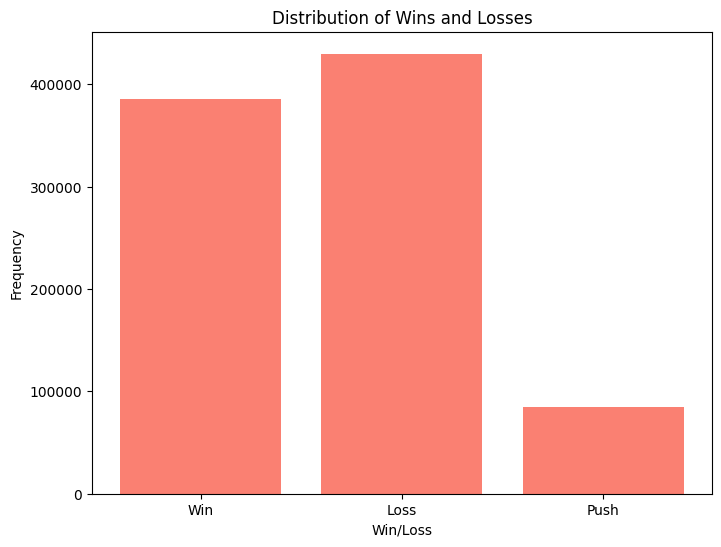

In [ ]:
plt.figure(figsize=(8, 6))
plt.bar(wins, counts, color='salmon')
plt.xlabel('Win/Loss')
plt.ylabel('Frequency')
plt.title('Distribution of Wins and Losses')
plt.show()

In [ ]:
player_final_values = df.select('sumofcards').rdd.flatMap(lambda x: x).collect()


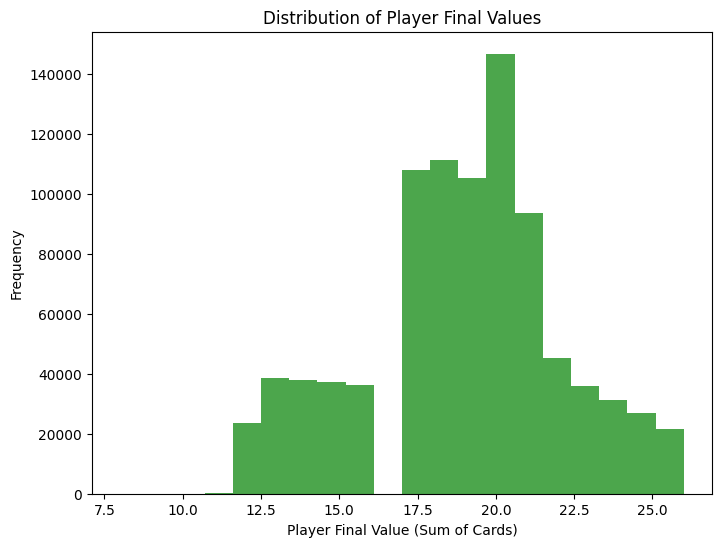

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(player_final_values, bins=20, color='green', alpha=0.7)
plt.xlabel('Player Final Value (Sum of Cards)')
plt.ylabel('Frequency')
plt.title('Distribution of Player Final Values')
plt.show()

In [ ]:
summary_stats = df.select(['sumofcards', 'plwinamt', 'dlwinamt']).summary("mean", "min", "max")

# Explore distribution of categorical variables
blkjck_counts = df.groupBy('blkjck').count().collect()
winloss_counts = df.groupBy('winloss').count().collect()
plybustbeat_counts = df.groupBy('plybustbeat').count().collect()
dlbustbeat_counts = df.groupBy('dlbustbeat').count().collect()
summary_stats.show()

+-------+-----------------+-----------------+-----------------+
|summary|       sumofcards|         plwinamt|         dlwinamt|
+-------+-----------------+-----------------+-----------------+
|   mean|18.89752222222222|9.723527777777777|4.775788888888889|
|    min|                8|                0|                0|
|    max|               26|               25|               10|
+-------+-----------------+-----------------+-----------------+



In [ ]:
def plot_categorical_counts(data, title):
    categories = [row[0] for row in data]
    counts = [row[1] for row in data]
    plt.figure(figsize=(8, 6))
    plt.bar(categories, counts, color='skyblue')
    plt.xlabel('Categories')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.show()

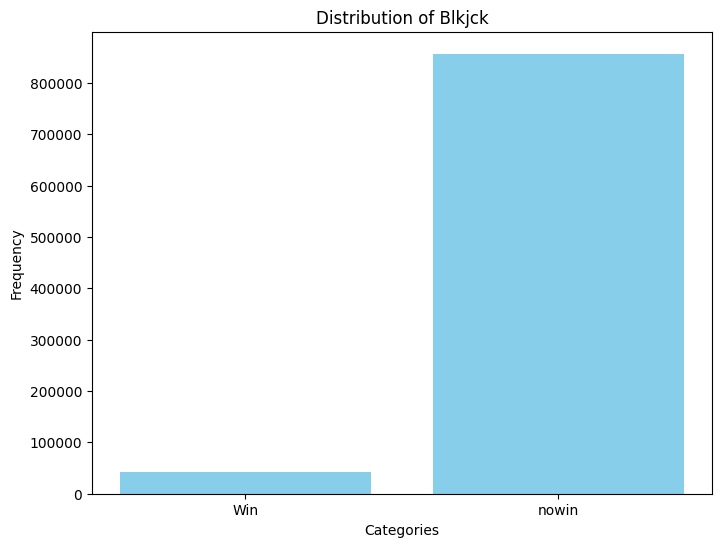

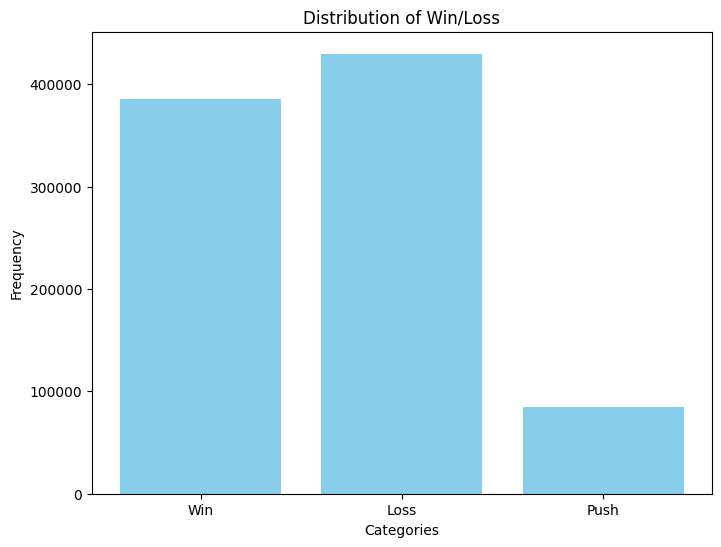

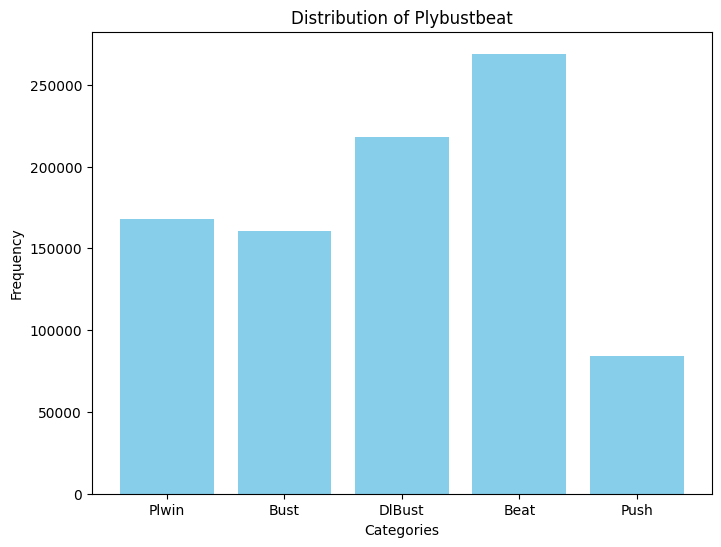

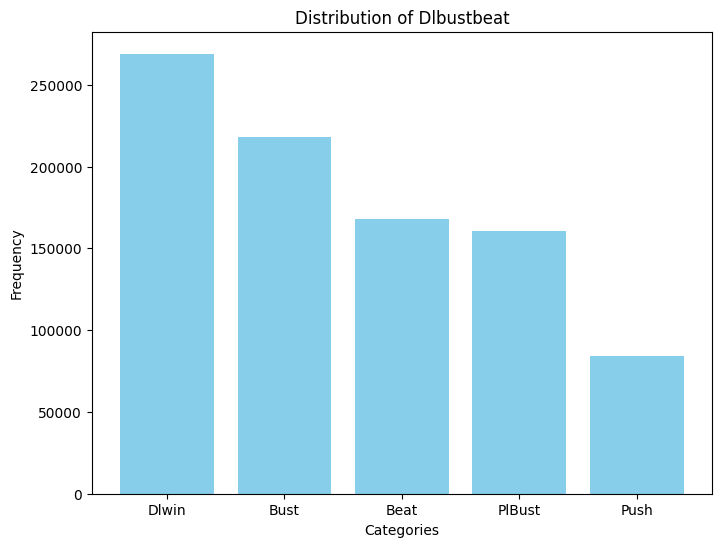

In [ ]:
plot_categorical_counts(blkjck_counts, 'Distribution of Blkjck')
plot_categorical_counts(winloss_counts, 'Distribution of Win/Loss')
plot_categorical_counts(plybustbeat_counts, 'Distribution of Plybustbeat')
plot_categorical_counts(dlbustbeat_counts, 'Distribution of Dlbustbeat')

In [ ]:
from pyspark.ml.feature import Imputer, StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

# Handle missing values with Imputer
imputer = Imputer(strategy='mean', inputCols=['sumofcards', 'plwinamt', 'dlwinamt'], outputCols=['sumofcards_imputed', 'plwinamt_imputed', 'dlwinamt_imputed'])
imputed_df = imputer.fit(df).transform(df)

# Convert categorical variables to numerical format
categorical_cols = ['blkjck', 'winloss', 'plybustbeat', 'dlbustbeat']

indexers = [StringIndexer(inputCol=col, outputCol=col+'_index') for col in categorical_cols]
encoder = OneHotEncoder(inputCols=[col+'_index' for col in categorical_cols], outputCols=[col+'_encoded' for col in categorical_cols])

pipeline = Pipeline(stages=indexers + [encoder])
processed_df = pipeline.fit(imputed_df).transform(imputed_df)

# Display processed dataframe
processed_df.show()

+---+--------+-----+-----+-----+-----+-----+----------+---------+---------+---------+---------+---------+---------+------+-------+-----------+----------+--------+--------+-----------+------------------+----------------+----------------+------------+-------------+-----------------+----------------+--------------+---------------+-------------------+------------------+
|_c0|PlayerNo|card1|card2|card3|card4|card5|sumofcards|dealcard1|dealcard2|dealcard3|dealcard4|dealcard5|sumofdeal|blkjck|winloss|plybustbeat|dlbustbeat|plwinamt|dlwinamt|ply2cardsum|sumofcards_imputed|plwinamt_imputed|dlwinamt_imputed|blkjck_index|winloss_index|plybustbeat_index|dlbustbeat_index|blkjck_encoded|winloss_encoded|plybustbeat_encoded|dlbustbeat_encoded|
+---+--------+-----+-----+-----+-----+-----+----------+---------+---------+---------+---------+---------+---------+------+-------+-----------+----------+--------+--------+-----------+------------------+----------------+----------------+------------+-------------

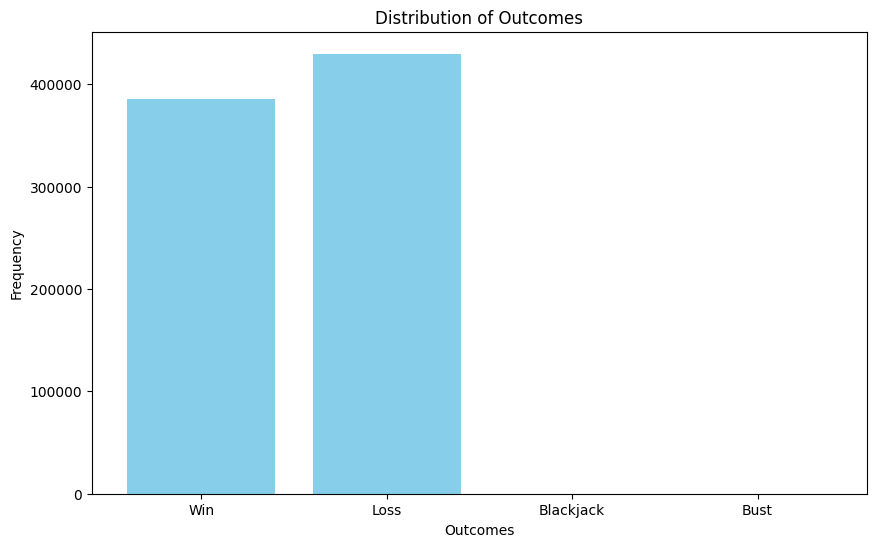

<Figure size 800x600 with 0 Axes>

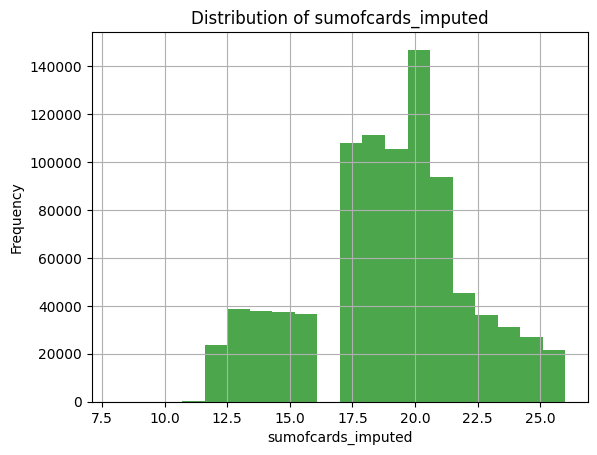

<Figure size 800x600 with 0 Axes>

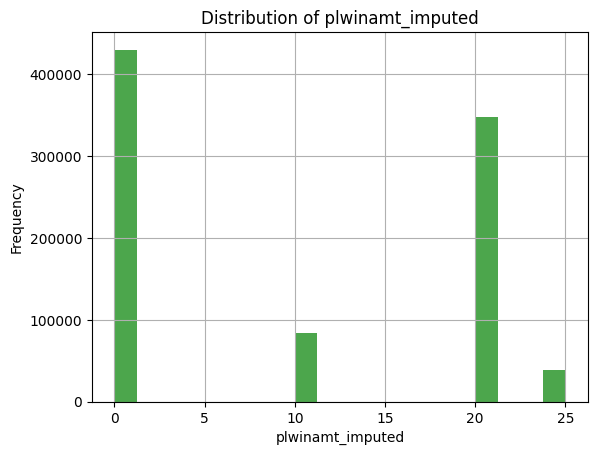

<Figure size 800x600 with 0 Axes>

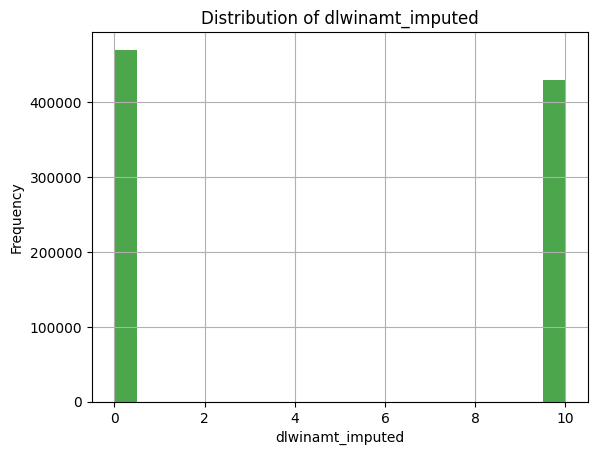

<Figure size 800x600 with 0 Axes>

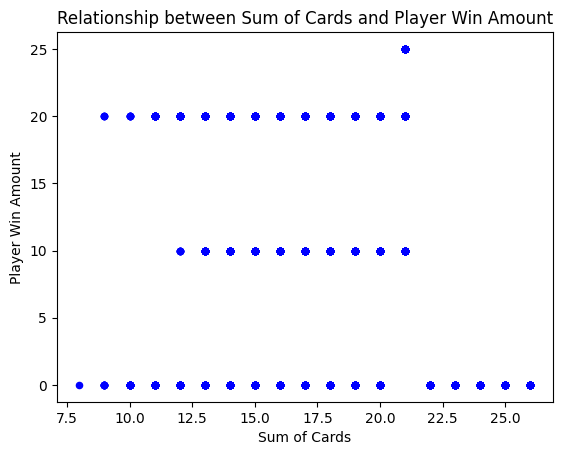

In [ ]:
import matplotlib.pyplot as plt

# Visualize distribution of outcomes (wins, losses, blackjack, busts)
outcomes_counts = processed_df.groupBy('winloss', 'blkjck', 'plybustbeat', 'dlbustbeat').count().collect()

outcomes_labels = ['Win', 'Loss', 'Blackjack', 'Bust']
outcomes_values = [processed_df.filter(col('winloss') == label).count() for label in outcomes_labels]

plt.figure(figsize=(10, 6))
plt.bar(outcomes_labels, outcomes_values, color='skyblue')
plt.xlabel('Outcomes')
plt.ylabel('Frequency')
plt.title('Distribution of Outcomes')
plt.show()

# Plot histograms for numerical features (card values, sums, win amounts)
numerical_features = ['sumofcards_imputed', 'plwinamt_imputed', 'dlwinamt_imputed']

for feature in numerical_features:
    plt.figure(figsize=(8, 6))
    processed_df.select(feature).toPandas().hist(bins=20, color='green', alpha=0.7)
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {feature}')
    plt.show()

# Use scatter plot to analyze relationship between sums of cards and win amounts
plt.figure(figsize=(8, 6))
processed_df.select('sumofcards_imputed', 'plwinamt_imputed').toPandas().plot.scatter(x='sumofcards_imputed', y='plwinamt_imputed', color='blue')
plt.xlabel('Sum of Cards')
plt.ylabel('Player Win Amount')
plt.title('Relationship between Sum of Cards and Player Win Amount')
plt.show()

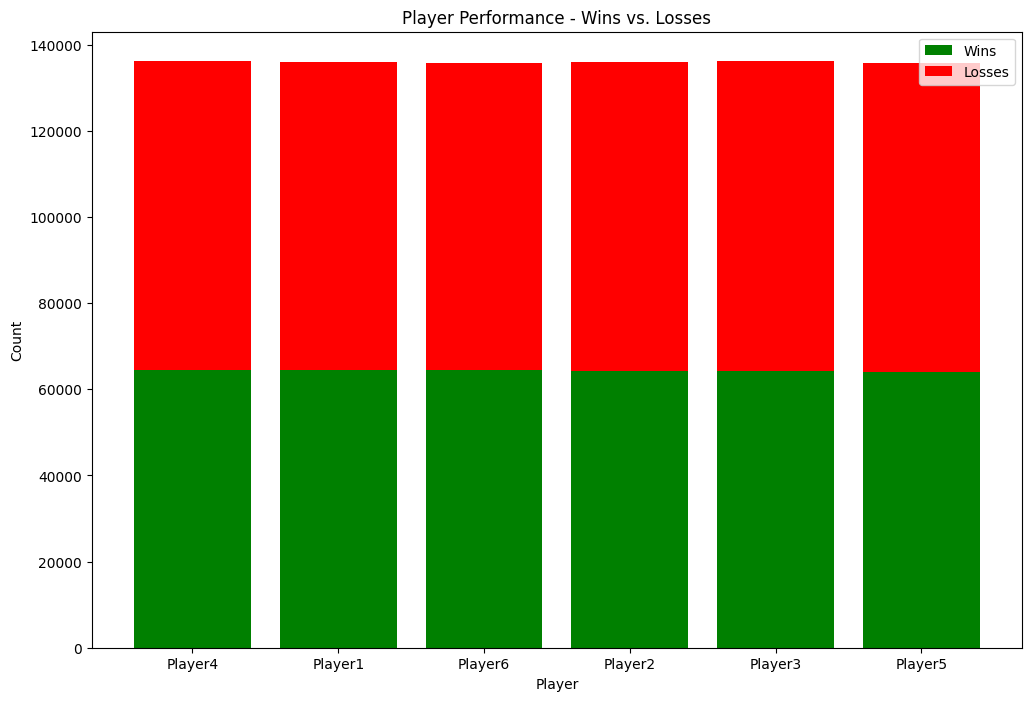

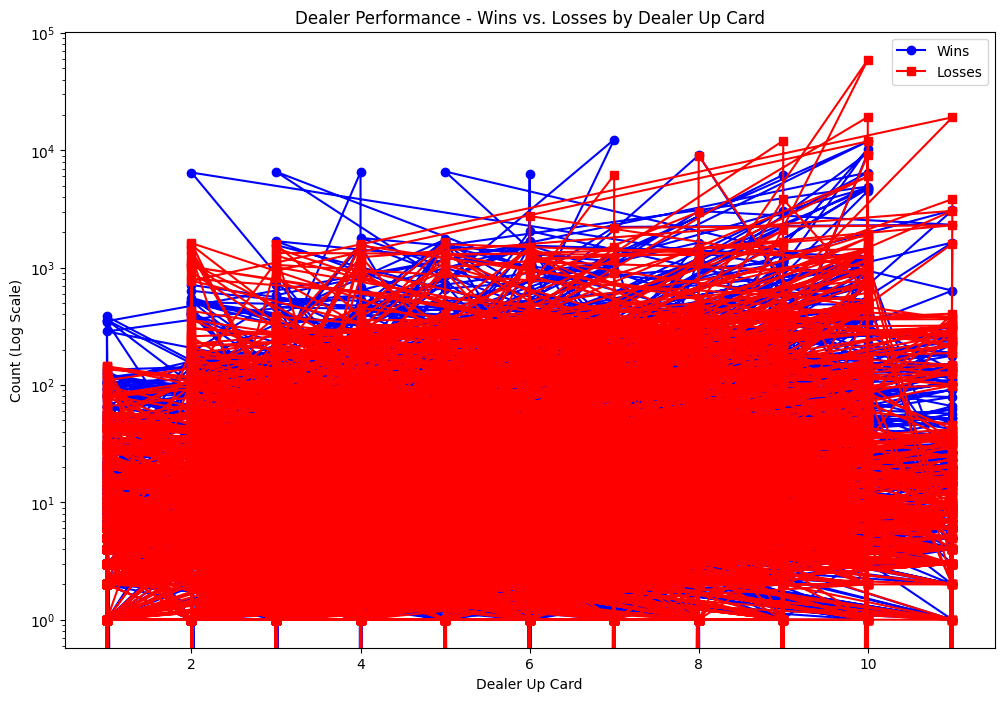

In [ ]:
from pyspark.sql.functions import avg, sum, count, when

# Player Analysis
# Group by 'PlayerNo' and calculate various metrics
player_analysis = processed_df.groupBy('PlayerNo').agg(
    count(when(col('winloss') == 'Win', 1)).alias('wins'),  # Count wins
    count(when(col('winloss') == 'Loss', 1)).alias('losses'),  # Count losses
    count(when(col('blkjck') == 'Blackjack', 1)).alias('blackjacks'),  # Count blackjacks
    count(when(col('plybustbeat') == 'Beat', 1)).alias('player_beats_dealer'),  # Count player beating dealer
    avg('plwinamt_imputed').alias('avg_win_amount')  # Calculate average win amount
)

# Visualize player performance using bar charts
# Convert player_analysis to Pandas dataframe for plotting
player_performance = player_analysis.toPandas()

# Plot bar chart comparing wins and losses for each player
plt.figure(figsize=(12, 8))
plt.bar(player_performance['PlayerNo'], player_performance['wins'], label='Wins', color='green')
plt.bar(player_performance['PlayerNo'], player_performance['losses'], label='Losses', color='red', bottom=player_performance['wins'])
plt.xlabel('Player')
plt.ylabel('Count')
plt.title('Player Performance - Wins vs. Losses')
plt.legend()
plt.show()

# Dealer Analysis
# Group by dealer's up cards and calculate metrics
dealer_analysis = processed_df.groupBy('dealcard1', 'dealcard2', 'dealcard3', 'dealcard4', 'dealcard5').agg(
    count(when(col('winloss') == 'Win', 1)).alias('dealer_wins'),  # Count dealer wins
    count(when(col('winloss') == 'Loss', 1)).alias('dealer_losses'),  # Count dealer losses
    avg('dlwinamt_imputed').alias('avg_dealer_win_amount')  # Calculate average dealer win amount
)

# Visualize dealer performance using line plots
# Convert dealer_analysis to Pandas dataframe for plotting
dealer_performance = dealer_analysis.toPandas()

# Plot line chart comparing wins and losses for each dealer's up card
plt.figure(figsize=(12, 8))
plt.plot(dealer_performance['dealcard1'], dealer_performance['dealer_wins'], marker='o', label='Wins', color='blue')
plt.plot(dealer_performance['dealcard1'], dealer_performance['dealer_losses'], marker='s', label='Losses', color='red')
plt.xlabel('Dealer Up Card')
plt.ylabel('Count (Log Scale)')
plt.title('Dealer Performance - Wins vs. Losses by Dealer Up Card')
plt.yscale('log')  # Set y-axis to log scale
plt.legend()
plt.show()


**next let us add a heat map for chanse of winningfor perticular hands**

X-axis (Dealer Up Card 1): This axis represents the dealer's up card. Each column in the heatmap corresponds to a specific value that the dealer's up card can take. For example, if the dealer's up card can be any value from 1 to 10, each column represents one of these values.

Y-axis (Sum of Player Cards): This axis represents the sum of the player's cards. Each row in the heatmap corresponds to a specific sum of player cards. For instance, if the sum of player cards can range from 1 to 21, each row represents one of these sums.

Color Gradient: The color of each cell in the heatmap indicates the win rate associated with the corresponding combination of player sum and dealer up card. Typically, a gradient color scheme is used where darker colors (e.g., shades of red) indicate higher win rates, and lighter colors (e.g., shades of blue) indicate lower win rates.

Annotations: In the heatmap generated with seaborn, annotations are added to each cell, displaying the exact win rate value for that combination. This provides a numerical representation of the win rates in addition to the visual color gradient.

Interpreting the Heatmap:

High Win Rates: Cells with darker colors (e.g., dark red) indicate combinations of player sum and dealer up card that are more likely to result in wins for the player. These are favorable combinations where the player has a higher chance of winning the hand.

Low Win Rates: Cells with lighter colors (e.g., light blue) represent combinations that are less favorable for the player, indicating lower win rates or higher probabilities of losing the hand.

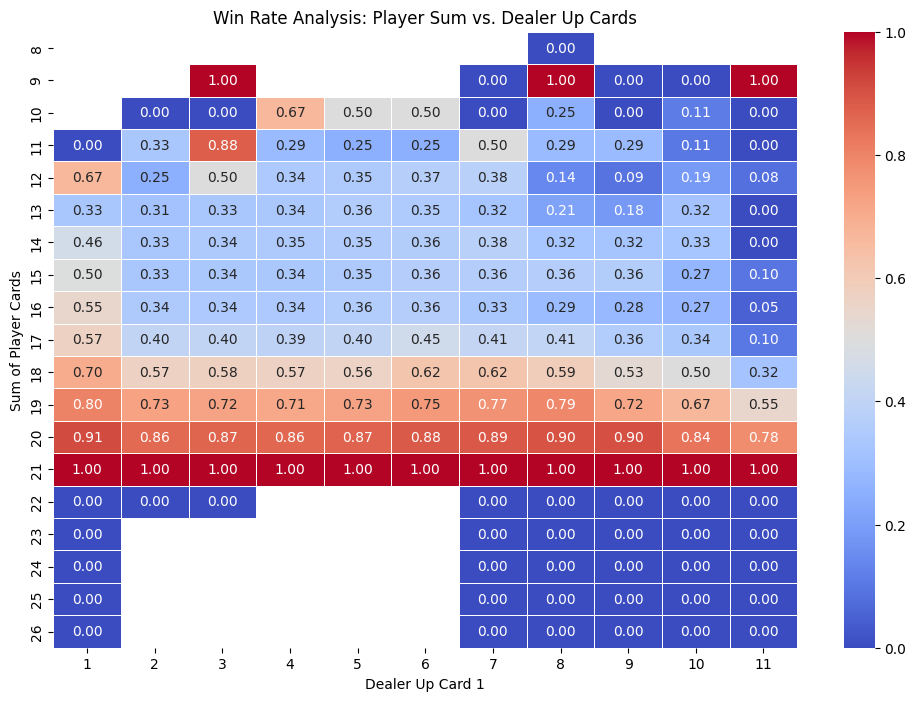

In [ ]:
import pandas as pd
import seaborn as sns

# Combine player and dealer data to analyze win/loss factors
combined_data = processed_df.select('PlayerNo', 'sumofcards_imputed', 'dealcard1', 'dealcard2', 'winloss')

# Calculate win rates for different combinations of player and dealer cards
win_rates_df = combined_data.groupBy('PlayerNo', 'sumofcards_imputed', 'dealcard1', 'dealcard2', 'winloss') \
    .agg(count('*').alias('count')) \
    .groupBy('PlayerNo', 'sumofcards_imputed', 'dealcard1', 'dealcard2') \
    .pivot('winloss', ['Win', 'Loss']) \
    .sum('count') \
    .fillna(0) \
    .withColumn('win_rate', col('Win') / (col('Win') + col('Loss')))

# Convert PySpark DataFrame to Pandas for easier visualization
win_rates_pd = win_rates_df.toPandas()

# Reshape data for heatmap using pivot_table
heatmap_data = win_rates_pd.pivot_table(index='sumofcards_imputed', columns='dealcard1', values='win_rate')

# Visualize win rates using a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5)
plt.xlabel('Dealer Up Card 1')
plt.ylabel('Sum of Player Cards')
plt.title('Win Rate Analysis: Player Sum vs. Dealer Up Cards')
plt.show()

In [ ]:
from pyspark.sql.functions import col

# Filter the processed dataframe to include entries for 'Player1' only
processed_df_player1 = processed_df.filter(col('PlayerNo') == 'Player1')

# Display processed dataframe for Player1
processed_df_player1.show()

+---+--------+-----+-----+-----+-----+-----+----------+---------+---------+---------+---------+---------+---------+------+-------+-----------+----------+--------+--------+-----------+------------------+----------------+----------------+------------+-------------+-----------------+----------------+--------------+---------------+-------------------+------------------+
|_c0|PlayerNo|card1|card2|card3|card4|card5|sumofcards|dealcard1|dealcard2|dealcard3|dealcard4|dealcard5|sumofdeal|blkjck|winloss|plybustbeat|dlbustbeat|plwinamt|dlwinamt|ply2cardsum|sumofcards_imputed|plwinamt_imputed|dlwinamt_imputed|blkjck_index|winloss_index|plybustbeat_index|dlbustbeat_index|blkjck_encoded|winloss_encoded|plybustbeat_encoded|dlbustbeat_encoded|
+---+--------+-----+-----+-----+-----+-----+----------+---------+---------+---------+---------+---------+---------+------+-------+-----------+----------+--------+--------+-----------+------------------+----------------+----------------+------------+-------------

[link text](https://)

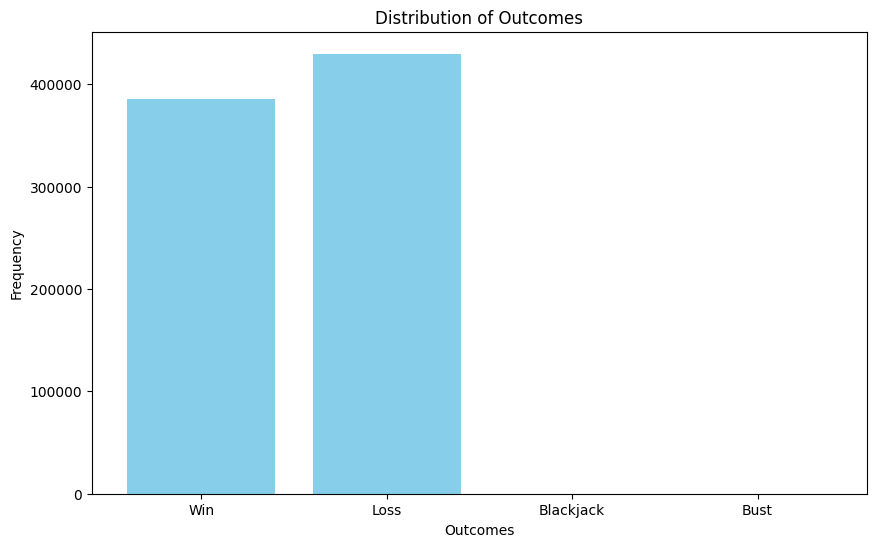

<Figure size 800x600 with 0 Axes>

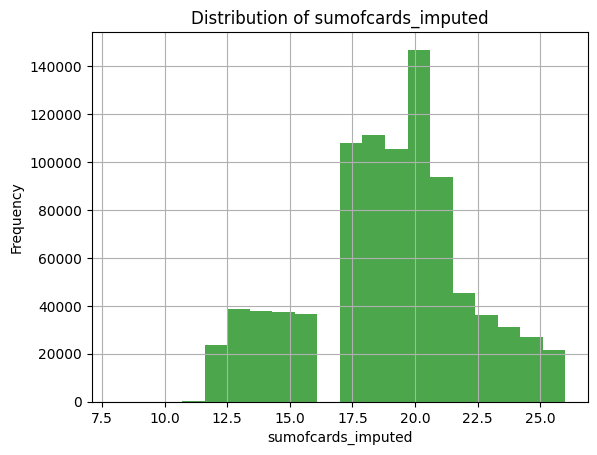

<Figure size 800x600 with 0 Axes>

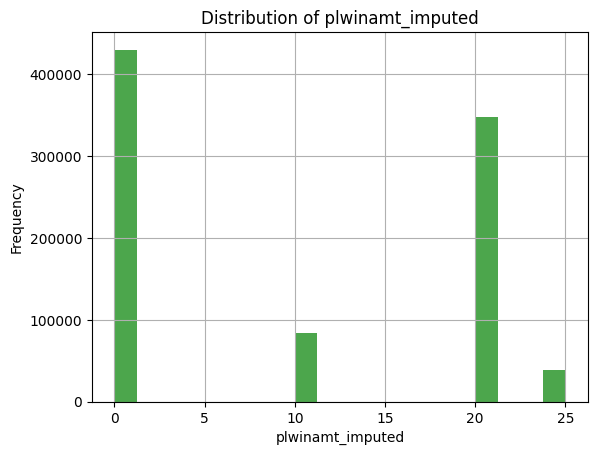

<Figure size 800x600 with 0 Axes>

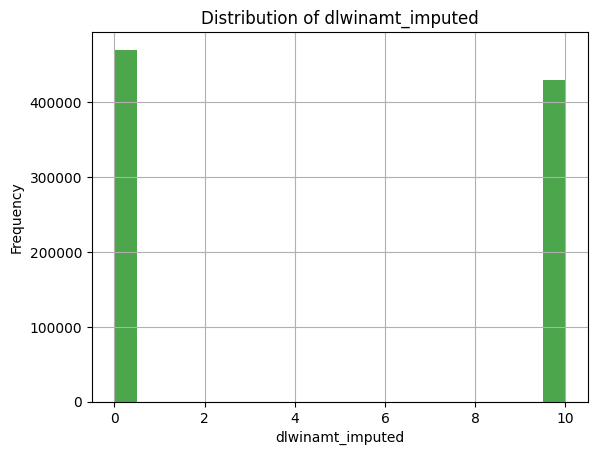

<Figure size 800x600 with 0 Axes>

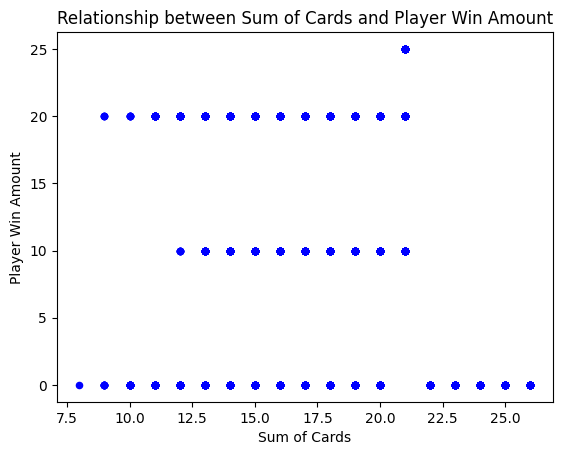

In [ ]:
import matplotlib.pyplot as plt

# Visualize distribution of outcomes (wins, losses, blackjack, busts)
outcomes_counts = processed_df.groupBy('winloss', 'blkjck', 'plybustbeat', 'dlbustbeat').count().collect()

outcomes_labels = ['Win', 'Loss', 'Blackjack', 'Bust']
outcomes_values = [processed_df.filter(col('winloss') == label).count() for label in outcomes_labels]

plt.figure(figsize=(10, 6))
plt.bar(outcomes_labels, outcomes_values, color='skyblue')
plt.xlabel('Outcomes')
plt.ylabel('Frequency')
plt.title('Distribution of Outcomes')
plt.show()

# Plot histograms for numerical features (card values, sums, win amounts)
numerical_features = ['sumofcards_imputed', 'plwinamt_imputed', 'dlwinamt_imputed']

for feature in numerical_features:
    plt.figure(figsize=(8, 6))
    processed_df.select(feature).toPandas().hist(bins=20, color='green', alpha=0.7)
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {feature}')
    plt.show()

# Use scatter plot to analyze relationship between sums of cards and win amounts
plt.figure(figsize=(8, 6))
processed_df.select('sumofcards_imputed', 'plwinamt_imputed').toPandas().plot.scatter(x='sumofcards_imputed', y='plwinamt_imputed', color='blue')
plt.xlabel('Sum of Cards')
plt.ylabel('Player Win Amount')
plt.title('Relationship between Sum of Cards and Player Win Amount')
plt.show()

In [1]:
import seaborn as sns

# Visualize distribution of outcomes using a pie chart
def plot_pie_chart(data, labels, title):
    plt.figure(figsize=(8, 8))
    plt.pie(data, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title(title)
    plt.axis('equal')
    plt.show()

outcomes_counts_dict = {row['winloss']: row['count'] for row in outcomes_counts}
plot_pie_chart(outcomes_counts_dict.values(), outcomes_counts_dict.keys(), 'Distribution of Outcomes')

# Plot box plots for numerical features
def plot_box_plot(data, x_label, y_label, title):
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=x_label, y=y_label, data=data)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.show()

plot_box_plot(processed_df.toPandas(), 'winloss', 'sumofcards_imputed', 'Box Plot of Sum of Cards by Outcome')

# Use pair plot for multivariate analysis
def plot_pair_plot(data, hue_col, title):
    plt.figure(figsize=(10, 8))
    sns.pairplot(data.toPandas(), hue=hue_col, markers=["o", "s", "D"], palette='husl')
    plt.title(title)
    plt.show()

plot_pair_plot(processed_df, 'winloss', 'Pair Plot of Numerical Features by Outcome')

NameError: name 'outcomes_counts' is not defined

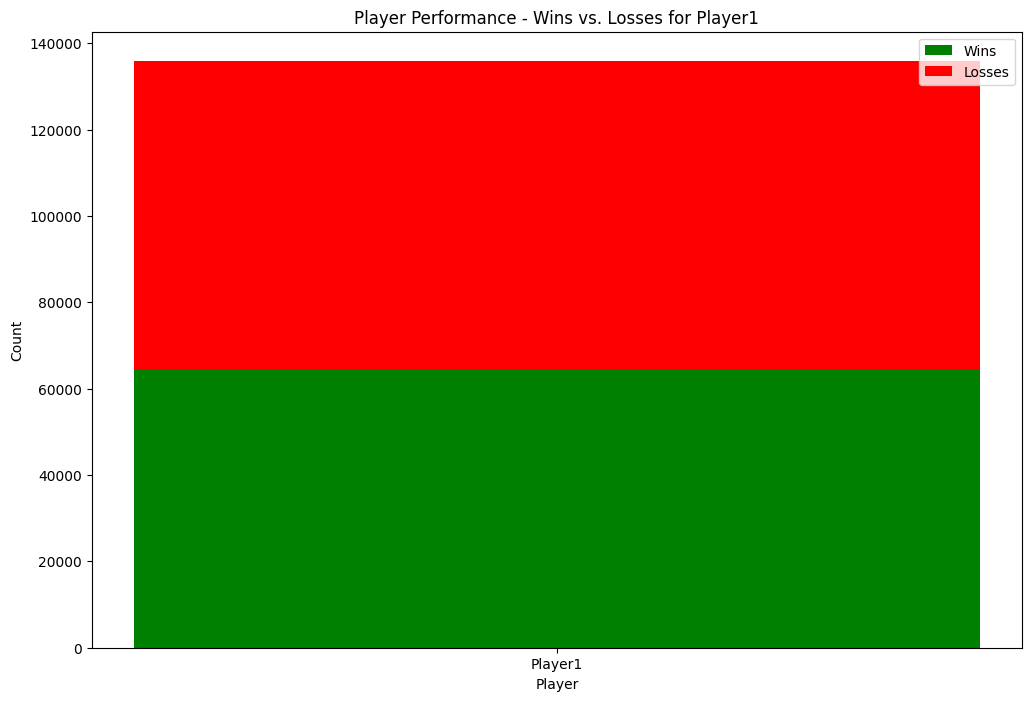

In [ ]:
from pyspark.sql.functions import avg, sum, count, when

# Player Analysis
# Group by 'PlayerNo' and calculate various metrics for Player1
player_analysis_player1 = processed_df_player1.groupBy('PlayerNo').agg(
    count(when(col('winloss') == 'Win', 1)).alias('wins'),  # Count wins
    count(when(col('winloss') == 'Loss', 1)).alias('losses'),  # Count losses
    count(when(col('blkjck') == 'Blackjack', 1)).alias('blackjacks'),  # Count blackjacks
    count(when(col('plybustbeat') == 'Beat', 1)).alias('player_beats_dealer'),  # Count player beating dealer
    avg('plwinamt_imputed').alias('avg_win_amount')  # Calculate average win amount
)

# Visualize player performance using bar charts
# Convert player_analysis_player1 to Pandas dataframe for plotting
player_performance_player1 = player_analysis_player1.toPandas()

# Plot bar chart comparing wins and losses for Player1
plt.figure(figsize=(12, 8))
plt.bar(player_performance_player1['PlayerNo'], player_performance_player1['wins'], label='Wins', color='green')
plt.bar(player_performance_player1['PlayerNo'], player_performance_player1['losses'], label='Losses', color='red', bottom=player_performance_player1['wins'])
plt.xlabel('Player')
plt.ylabel('Count')
plt.title('Player Performance - Wins vs. Losses for Player1')
plt.legend()
plt.show()


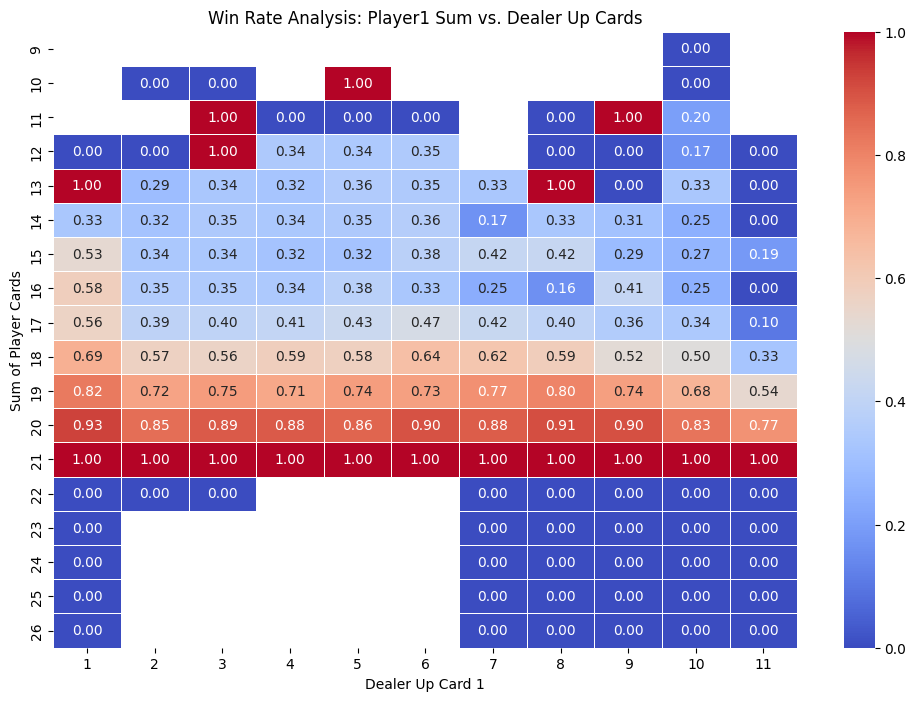

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Combine player and dealer data to analyze win/loss factors for Player1
combined_data_player1 = processed_df_player1.select('PlayerNo', 'sumofcards_imputed', 'dealcard1', 'dealcard2', 'winloss')

# Calculate win rates for different combinations of player and dealer cards for Player1
win_rates_df_player1 = combined_data_player1.groupBy('PlayerNo', 'sumofcards_imputed', 'dealcard1', 'dealcard2', 'winloss') \
    .agg(count('*').alias('count')) \
    .groupBy('PlayerNo', 'sumofcards_imputed', 'dealcard1', 'dealcard2') \
    .pivot('winloss', ['Win', 'Loss']) \
    .sum('count') \
    .fillna(0) \
    .withColumn('win_rate', col('Win') / (col('Win') + col('Loss')))

# Convert PySpark DataFrame to Pandas for easier visualization
win_rates_pd_player1 = win_rates_df_player1.toPandas()

# Reshape data for heatmap using pivot_table
heatmap_data_player1 = win_rates_pd_player1.pivot_table(index='sumofcards_imputed', columns='dealcard1', values='win_rate')

# Visualize win rates using a heatmap for Player1
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data_player1, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5)
plt.xlabel('Dealer Up Card 1')
plt.ylabel('Sum of Player Cards')
plt.title('Win Rate Analysis: Player1 Sum vs. Dealer Up Cards')
plt.show()



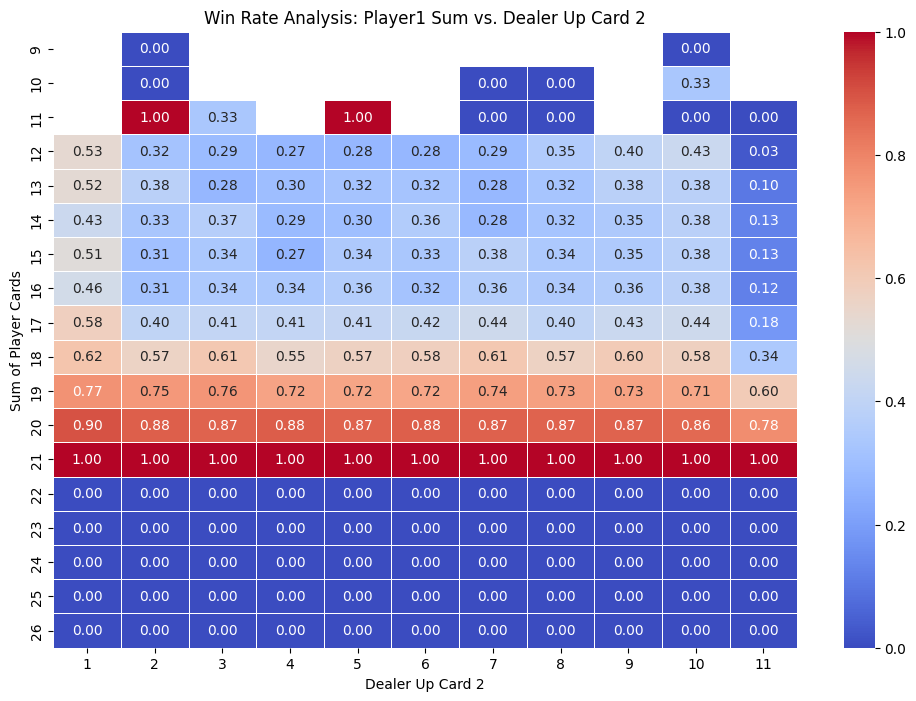

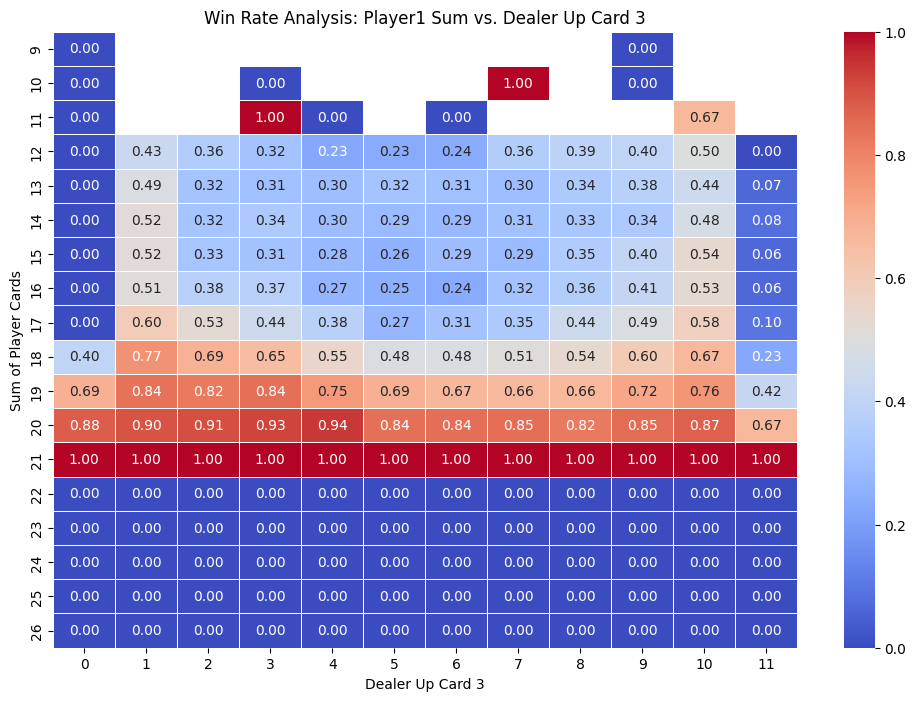

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, count

# Combine player and dealer data to analyze win/loss factors for Player1
combined_data_player1 = processed_df_player1.select('PlayerNo', 'sumofcards_imputed', 'dealcard1', 'dealcard2', 'dealcard3', 'winloss')

# Calculate win rates for different combinations of player and dealer cards for Player1
win_rates_df_player1 = combined_data_player1.groupBy('PlayerNo', 'sumofcards_imputed', 'dealcard1', 'dealcard2', 'dealcard3', 'winloss') \
    .agg(count('*').alias('count')) \
    .groupBy('PlayerNo', 'sumofcards_imputed', 'dealcard1', 'dealcard2', 'dealcard3') \
    .pivot('winloss', ['Win', 'Loss']) \
    .sum('count') \
    .fillna(0) \
    .withColumn('win_rate', col('Win') / (col('Win') + col('Loss')))

# Convert PySpark DataFrame to Pandas for easier visualization
win_rates_pd_player1 = win_rates_df_player1.toPandas()

# Reshape data for heatmap using pivot_table for dealer up card 2
heatmap_data_dealer_up_card2 = win_rates_pd_player1.pivot_table(index='sumofcards_imputed', columns='dealcard2', values='win_rate')

# Visualize win rates using a heatmap for dealer up card 2
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data_dealer_up_card2, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5)
plt.xlabel('Dealer Up Card 2')
plt.ylabel('Sum of Player Cards')
plt.title('Win Rate Analysis: Player1 Sum vs. Dealer Up Card 2')
plt.show()

# Reshape data for heatmap using pivot_table for dealer up card 3
heatmap_data_dealer_up_card3 = win_rates_pd_player1.pivot_table(index='sumofcards_imputed', columns='dealcard3', values='win_rate')

# Visualize win rates using a heatmap for dealer up card 3
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data_dealer_up_card3, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5)
plt.xlabel('Dealer Up Card 3')
plt.ylabel('Sum of Player Cards')
plt.title('Win Rate Analysis: Player1 Sum vs. Dealer Up Card 3')
plt.show()


ML


In [ ]:
# Select relevant features for predictive modeling
features = ['sumofcards_imputed', 'dealcard1', 'dealcard2']
assembler = VectorAssembler(inputCols=features, outputCol='features')
data = assembler.transform(processed_df_player1)

# Split the data into training and testing sets (80% training, 20% testing)
train_data, test_data = data.randomSplit([0.8, 0.2], seed=123)
# Initialize the decision tree classifier
dt_classifier = DecisionTreeClassifier(featuresCol='features', labelCol='winloss_index')

# Train the model using the training data
dt_model = dt_classifier.fit(train_data)


In [ ]:
# Make predictions on the testing data
predictions = dt_model.transform(test_data)

# Evaluate model performance using a classification evaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol='winloss_index', metricName='accuracy')
accuracy = evaluator.evaluate(predictions)
print(f'Accuracy: {accuracy}')


Accuracy: 0.7399973147153598


In [ ]:
# Select features for clustering analysis
cluster_features = ['sumofcards_imputed', 'dealcard1', 'dealcard2', 'plwinamt_imputed']
cluster_assembler = VectorAssembler(inputCols=cluster_features, outputCol='cluster_features')
cluster_data = cluster_assembler.transform(processed_df_player1)


In [ ]:
# Initialize k-means clustering model
kmeans = KMeans(featuresCol='cluster_features', predictionCol='cluster_prediction', k=3)

# Fit the k-means model to the data
kmeans_model = kmeans.fit(cluster_data)

# Get the clustered data
clustered_data = kmeans_model.transform(cluster_data)


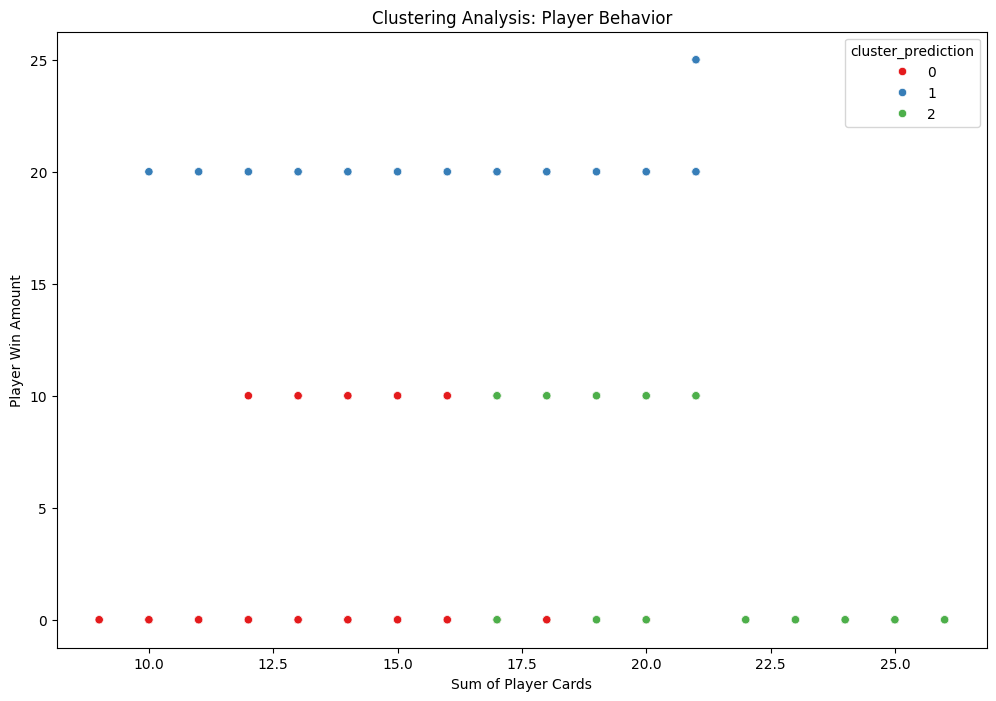

In [ ]:
# Convert clustered data to Pandas dataframe for analysis
clustered_pd = clustered_data.select('sumofcards_imputed', 'dealcard1', 'dealcard2', 'plwinamt_imputed', 'cluster_prediction').toPandas()

# Visualize clusters using scatter plots
plt.figure(figsize=(12, 8))
sns.scatterplot(data=clustered_pd, x='sumofcards_imputed', y='plwinamt_imputed', hue='cluster_prediction', palette='Set1')
plt.xlabel('Sum of Player Cards')
plt.ylabel('Player Win Amount')
plt.title('Clustering Analysis: Player Behavior')
plt.show()


+--------+------------------+----------+------------+-------------------+
|PlayerNo|sumofcards_imputed|total_wins|total_losses|    win_probability|
+--------+------------------+----------+------------+-------------------+
| Player1|                14|      2398|        3822| 0.3855305466237942|
| Player3|                14|      2498|        3834|0.39450410612760584|
| Player3|                19|      9770|        5355| 0.6459504132231405|
| Player5|                10|         1|           4|                0.2|
| Player3|                 9|         1|           2| 0.3333333333333333|
| Player2|                23|         0|        5972|                0.0|
| Player6|                19|      9735|        5471|  0.640207812705511|
| Player3|                16|      2328|        3749|0.38308375843343756|
| Player6|                21|     13683|           0|                1.0|
| Player4|                13|      2512|        3909|0.39121632144525775|
| Player4|                14|      245

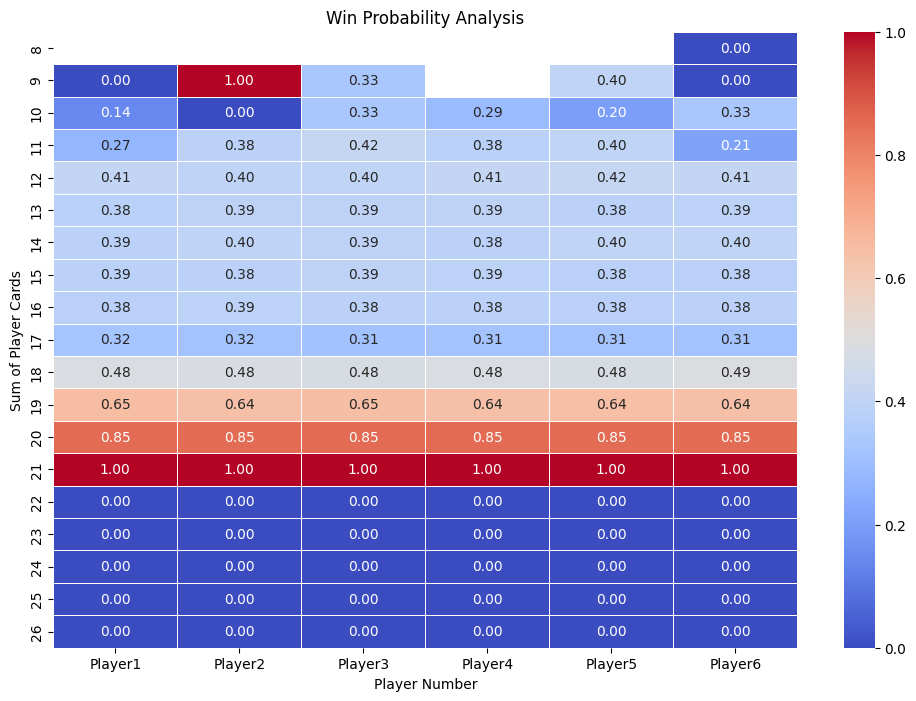

In [ ]:
# Import necessary libraries
from pyspark.sql import functions as F

# Group by 'PlayerNo', 'sumofcards_imputed', and 'winloss' and count occurrences
win_loss_counts = processed_df.groupBy('PlayerNo', 'sumofcards_imputed', 'winloss') \
    .count() \
    .orderBy('PlayerNo', 'sumofcards_imputed', 'winloss')

# Calculate total counts of wins and losses for each player card sum
total_counts = win_loss_counts.groupBy('PlayerNo', 'sumofcards_imputed') \
    .agg(F.sum(F.when(F.col('winloss') == 'Win', F.col('count')).otherwise(0)).alias('total_wins'),
         F.sum(F.when(F.col('winloss') == 'Loss', F.col('count')).otherwise(0)).alias('total_losses'))

# Calculate win probability for each combination
win_probabilities = total_counts.withColumn('win_probability', F.col('total_wins') / (F.col('total_wins') + F.col('total_losses')))

# Show the calculated win probabilities
win_probabilities.show()

# Optionally, visualize the win probabilities using a heatmap or other suitable visualization
# You can convert the win_probabilities DataFrame to Pandas and use libraries like seaborn to create visualizations
# For example:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

win_probabilities_pd = win_probabilities.toPandas()

# Create a heatmap to visualize win probabilities
heatmap_data = win_probabilities_pd.pivot_table(index='sumofcards_imputed', columns='PlayerNo', values='win_probability')

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5)
plt.xlabel('Player Number')
plt.ylabel('Sum of Player Cards')
plt.title('Win Probability Analysis')
plt.show()


In [6]:
# Filter the processed_df to include data for only one player
player_df = processed_df.filter(processed_df.PlayerNo == 'Player1')

# Group by 'sumofcards_imputed' and 'winloss' to count occurrences
win_loss_counts = player_df.groupBy('sumofcards_imputed', 'winloss') \
    .count() \
    .orderBy('sumofcards_imputed', 'winloss')

# Calculate total counts of wins and losses for each player card sum
total_counts = win_loss_counts.groupBy('sumofcards_imputed') \
    .agg(F.sum(F.when(F.col('winloss') == 'Win', F.col('count')).otherwise(0)).alias('total_wins'),
         F.sum(F.when(F.col('winloss') == 'Loss', F.col('count')).otherwise(0)).alias('total_losses'))

# Calculate win probability for each card sum
win_probabilities = total_counts.withColumn('win_probability', F.col('total_wins') / (F.col('total_wins') + F.col('total_losses')))

# Show the calculated win probabilities
win_probabilities.show()

# Optionally, visualize the win probabilities using a heatmap
# Convert the win_probabilities DataFrame to Pandas and use seaborn for visualization
win_probabilities_pd = win_probabilities.toPandas()

# Create a heatmap to visualize win probabilities
plt.figure(figsize=(12, 2))
sns.heatmap(win_probabilities_pd[['sumofcards_imputed', 'win_probability']].set_index('sumofcards_imputed').T, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5)
plt.xlabel('Sum of Player Cards')
plt.ylabel('Win Probability')
plt.title('Win Probability Analysis for Player 1')
plt.show()



NameError: name 'processed_df' is not defined